# torchvision 을 사용하여 CIFAR10 불러오기

In [1]:
import torch  #pytorch 이용
import torchvision #이미지 처리 패키지, 예제 데이터인 CIFAR10 포함
import torchvision.transforms as transforms  #이미지 변환 패키지

# 정규화된 Tensor로 변환

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), # 이미지를 텐서로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #평균 0.5, 표준편차 0.5로 표준화 (x-m)/s

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  # 훈련데이터 다운로드
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,   # 훈련데이터를 연산하기 위하여 CPU로 불러옴, 미니배치크기=4 
                                          shuffle=True, num_workers=2) #랜덤으로, cpu 2개로.

testset = torchvision.datasets.CIFAR10(root='./data', train=False,  #검증데이터 다운로드
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,  #검증데이터를 연산하기 위하여 CPU로 불러옴, 미니배치크기=4
                                         shuffle=False, num_workers=2) 

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') #사진의 범주

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 현재 위치 및 데이터 위치 확인

In [ ]:
! pwd

/content


In [ ]:
% cd ./data/

/content/data


In [ ]:
! ls

cifar-10-batches-py  cifar-10-python.tar.gz


# 학습용 데이터 이미지 확인(일부)

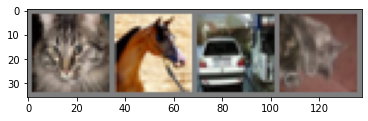

  cat horse   car   cat


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기. 
dataiter = iter(trainloader) #반복속성을 갖도로 지정. iter
images, labels = dataiter.next() 

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

CNN 정의하기

In [4]:
import torch.nn as nn
import torch.nn.functional as F 


class Net(nn.Module): # 기존에 만들어진 신경망 구조 class 상속
    def __init__(self): # 신경망 구조 설계
        super(Net, self).__init__() # 초기화
        self.conv1 = nn.Conv2d(3, 6, 5) # 입력채널 3개, 출력채널 6개, 커널크기 5*5
        self.pool = nn.MaxPool2d(2, 2)  # 커널 크기 2*2, 스트라이드 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #입력, 출력
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x): #신경망 연산 설계
        x = self.pool(F.relu(self.conv1(x))) #입력 -> conv1 -> relu-> pool 
        x = self.pool(F.relu(self.conv2(x))) #입력 -> conv2 -> relu-> pool
        x = x.view(-1, 16 * 5 * 5) # flatten
        x = F.relu(self.fc1(x)) # 입력 -> fc1 -> relu
        x = F.relu(self.fc2(x)) # 입력 -> fc2 -> relu
        x = self.fc3(x) # 입력 -> fc3
        return x


net = Net() #위에서 정의한 신경망구조를 net으로 선언

# 손실함수와 Optimizer 정의하기 : Cross-Entropy loss, 모멘텀(momentum) 값을 갖는  SGD 사용

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #loss를 크로스 엔트로피로 지정
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #net으로 정의된 구조에서 parameter들을 최적화. 학습률 0.001, 모멘텀 0.9

#신경망 학습하기

In [6]:
for epoch in range(2):   # 전체 데이터셋에 대해 2회 반복하여 학습

    running_loss = 0.0 # 초기화
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 list로 구성된 data로부터 입력을 받은 후;
        inputs, labels = data
        optimizer.zero_grad() # parameter의 Gradient를 0으로 초기화
        outputs = net(inputs) # net의 구조를 통한 출력값 계산
        loss = criterion(outputs, labels) #출력값과 true label을 비교하여 loss계산
        loss.backward() # loss를 전파하며 gradient 계산
        optimizer.step() # parameter 업데이트

        # loss 출력
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2000 mini-batch마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000)) #2000개 mini-batch의 평균 loss
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.221
[1,  4000] loss: 1.912
[1,  6000] loss: 1.695
[1,  8000] loss: 1.606
[1, 10000] loss: 1.533
[1, 12000] loss: 1.462
[2,  2000] loss: 1.385
[2,  4000] loss: 1.377
[2,  6000] loss: 1.331
[2,  8000] loss: 1.324
[2, 10000] loss: 1.286
[2, 12000] loss: 1.264
Finished Training


#검증용 데이터로 성능 검증

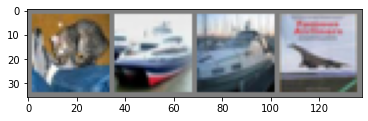

GroundTruth:    cat  ship  ship plane


In [13]:
dataiter = iter(testloader) # 검증용 데이터 불러오기
images, labels = dataiter.next() #첫번째 이미지

# 샘플 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [15]:
outputs = net(images) # 샘플 이미지를 앞에서 학습한 net 구조에 적용. 출력값 산출


In [16]:
_, predicted = torch.max(outputs, 1) #예측값 중에서 값이 최대인 범주 선택

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] # 4개의 이미지의 예측 범주 출력
                              for j in range(4)))

Predicted:    cat   car  ship plane


전체 검증 데이터의 정확도 

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %
